In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from qiskit.primitives import Sampler,Estimator
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
from qiskit.algorithms.gradients import ParamShiftEstimatorGradient,ParamShiftSamplerGradient
from qiskit.circuit import ParameterVector
%matplotlib inline


/var/folders/9v/dz00k5396wl369lhxwggy12m0000gn/T/ipykernel_4129/69454660.py:9: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.gradients import ParamShiftEstimatorGradient,ParamShiftSamplerGradient


In [2]:
from VQS_header import compute_params_list,compute_magnetization,make_magnetization_op

In [36]:
num_qubits = 3
j_coupling = 1/4
h_coupling = 1

num_layers = 3
time_max = 5e0
epsilon_det = 1e-7
num_steps = 100
sampler = Sampler()
estimator = Estimator()
nShots=None

dt=time_max/num_steps
sampler=Sampler()

print("dt = ",dt)

dt =  0.05


In [37]:
def addSuzukiTrotter(circuit,j,h,dt):
    num_qubits=circuit.num_qubits
    #Implementing Suzuki-Trotter evolution step for the transverse Ising
    for i in range(num_qubits):
        circuit.rx(-2*h*dt,i)
    
    for i in range(num_qubits-1):
        circuit.rzz(-2*j*dt,i,i+1)
    return circuit

def getAnsatz(num_qubits,n_layers=3,weight_name="weight"):
    n_params=n_layers*(2*num_qubits-1)
    ansatz = QuantumCircuit(num_qubits,num_qubits) 
    weights = ParameterVector(weight_name, n_params)
    params_index=0
    for layer in range(num_layers):
        for i in range(num_qubits):
            ansatz.rx(weights[params_index],i)
            params_index+=1
        for i in range(num_qubits-1):
            ansatz.rzz(weights[params_index],i,i+1)
            params_index+=1
            
    return ansatz
    

def getCircuit(num_qubits,n_layers=3,j=j_coupling,h=h_coupling,dt=dt):
    circuit = QuantumCircuit(num_qubits,num_qubits) 
    
    ansatz = getAnsatz(num_qubits,n_layers=n_layers)
    ansatz_inv = getAnsatz(num_qubits,n_layers=n_layers,weight_name="weight_inverse").inverse()
    
    circuit.compose(ansatz_inv, inplace=True)
    circuit.barrier()
    addSuzukiTrotter(circuit,j,h,dt)
    circuit.barrier()
    circuit.compose(ansatz, inplace=True)  
    
    circuit.measure(circuit.qubits,circuit.clbits)
    return circuit

def computeMag(num_qubits,n_layers,weights,estimator=estimator):
    observable = make_magnetization_op(num_qubits)
    ansatz = getAnsatz(num_qubits,n_layers=n_layers)
    job = estimator.run(circuits=[ansatz], observables=[observable],parameter_values=[weights])
    return job.result().values[0]

def compute_energy(weights,num_qubits,n_layers,j_coupling,h_coupling,estimator=estimator):

    ansatz = getAnsatz(num_qubits,n_layers=n_layers)
    observable=SparsePauliOp.from_list([("X"+"I"*(num_qubits-1) , -h_coupling )])
    
    for i in np.arange(1,num_qubits,1):
        observable=observable + SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(num_qubits-1-i) , -h_coupling )])
        
    for i in np.arange(0,num_qubits-1,1):
        observable=observable + (SparsePauliOp.from_list([("I"*(i)+"ZZ"+"I"*(num_qubits-2-i) ,-j_coupling)]))

    
    job=estimator.run(circuits=[ansatz], observables=[observable],parameter_values=[weights]
                          )


    return job.result().values[0]

    
    

In [38]:
qc = getCircuit(num_qubits,n_layers=num_layers)

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


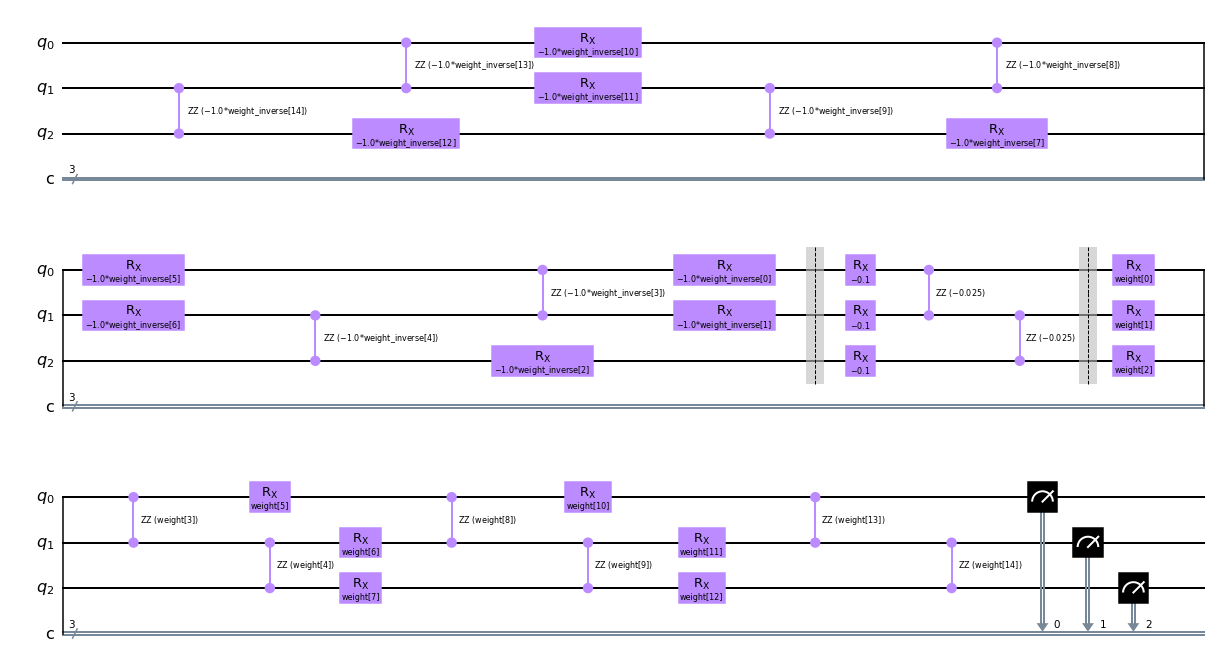

In [39]:
qc.draw('mpl')

In [40]:
def paramShift(weights,sampler=sampler):
    weights_list=[weights]
    for i in range(n_params_ansatz):
        weightsPlus=weights.copy()
        weightsPlus[i]+=np.pi/2
        weights_list.append(weightsPlus)

        weightsMinus=weights.copy()
        weightsMinus[i]-=np.pi/2
        weights_list.append(weightsMinus)

    results=sampler.run(circuits=[qc]*len(weights_list),parameter_values=weights_list).result().quasi_dists
    output=results[0][0]
    
    grad_list=[]
    for i in range(n_params_ansatz):
        tmpGrad_output=0.5*(results[2*i+1][0] - results[2*i+2][0])
        tmpGrad = -(2*(1-output)/(dt**2))*tmpGrad_output
        grad_list.append(tmpGrad)
    loss=((1-output)**2)/(dt**2)
    return loss,np.array(grad_list)

In [41]:
print("dt = ",dt)
learning_rate=2e-1
nIterations=50

n_params_ansatz=int(qc.num_parameters/2)
#Preparing weights, starting with same weights for both ansatz and its inverse
weights_init=np.random.rand(n_params_ansatz)
weights_init=np.concatenate([weights_init,weights_init])
weights=weights_init.copy()

weights_list=[]
loss_list=[]

for step in range(num_steps):
    
    
    for Iter in range(nIterations):
        loss,grad_list=paramShift(weights,sampler=sampler)
        weights[0:n_params_ansatz]-=learning_rate*grad_list
        
        if step==0:
            initial_loss=loss
        if loss<1e-5 or Iter==nIterations-1:
            #print(Iter,loss)
            break
    print(loss)
    weights[n_params_ansatz:]=weights[0:n_params_ansatz]
    loss_list.append(initial_loss)
    weights_list.append(weights[0:n_params_ansatz].copy())
    
    if step % 5 ==0:
        print("Step ",step, "done")


dt =  0.05
1.0867239562110161e-05
Step  0 done
1.0091371050011802e-05
9.921603460602026e-06
9.728649532660673e-06
9.781702882786459e-06
9.755558757640416e-06
Step  5 done
9.966158750065342e-06
9.721104490904484e-06
9.806602464558594e-06
9.57294275072017e-06
9.620669825628304e-06
Step  10 done
9.59801298211316e-06
9.455948365145272e-06
9.780019220204466e-06
9.824557955614514e-06
9.55853299569007e-06
Step  15 done
9.707307035160895e-06
9.70719110441543e-06
9.74931957018409e-06
9.986270021414708e-06
9.875057540865857e-06
Step  20 done
9.968744985500995e-06
1.2079119618665947e-05
1.4540061355728312e-05
1.7359702486588933e-05
2.048653133271559e-05
Step  25 done
2.3798588764208097e-05
2.7113906758418025e-05
3.0218375738437703e-05
3.2901707384636905e-05
3.499137114815403e-05
Step  30 done
3.6376785411314584e-05
3.7019475301182167e-05
3.69485810008581e-05
3.6244806320559665e-05
3.501882066507983e-05
Step  35 done
3.339098970730071e-05
3.147747793852989e-05
2.938408703923225e-05
2.7205653422019

In [42]:
mag_list_VQD=[]
energy_list_VQD=[]
for step in range(num_steps):
    
    mag=computeMag(num_qubits,num_layers,weights_list[step])
    energy=compute_energy(weights_list[step],num_qubits,num_layers,j_coupling,h_coupling,estimator=estimator)
    mag_list_VQD.append(mag)
    energy_list_VQD.append(energy)

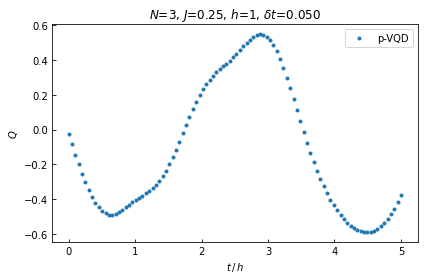

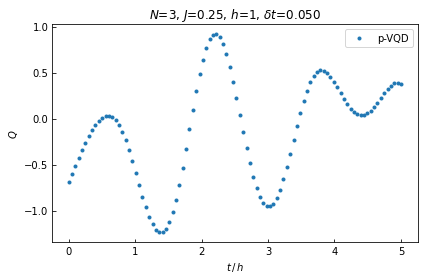

In [43]:

times_VQS = np.linspace(0.0,time_max,num_steps)
step = 1
plt.figure(1)
plt.plot(times_VQS[::step],mag_list_VQD[::step],'.',label='p-VQD')
plt.title(f'$N$={num_qubits}, $J$={j_coupling}, $h$={h_coupling}, $\delta t$={time_max/num_steps:.3f}')
plt.xlabel('$t\, / \, h$')
plt.ylabel('$Q$')
# plt.xlim([0,0.1])
plt.legend()
plt.tight_layout()
# plt.savefig(f'magnetization_N{num_qubits}_J{j_coupling}_h{h_coupling}_dt{time_max/num_steps:.2f}_v1.pdf')
plt.show()


plt.figure(2)
plt.plot(times_VQS[::step],energy_list_VQD[::step],'.',label='p-VQD')
plt.title(f'$N$={num_qubits}, $J$={j_coupling}, $h$={h_coupling}, $\delta t$={time_max/num_steps:.3f}')
plt.xlabel('$t\, / \, h$')
plt.ylabel('$Q$')
# plt.xlim([0,0.1])
plt.legend()
plt.tight_layout()
# plt.savefig(f'magnetization_N{num_qubits}_J{j_coupling}_h{h_coupling}_dt{time_max/num_steps:.2f}_v1.pdf')
plt.show()